# Прогнозирование оттока клиентов с использованием методов деревьев решений

Цель - создать модель, которая предскажет произойдет ли отток клиента или нет.

### Загрузка данных и необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


-----
## 1) Работа с данными

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [62]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Целевая колонка в данных - 'Churn', - означает ушел ли клиент в "отток" или нет. 
### Посмотрим на количественный график:

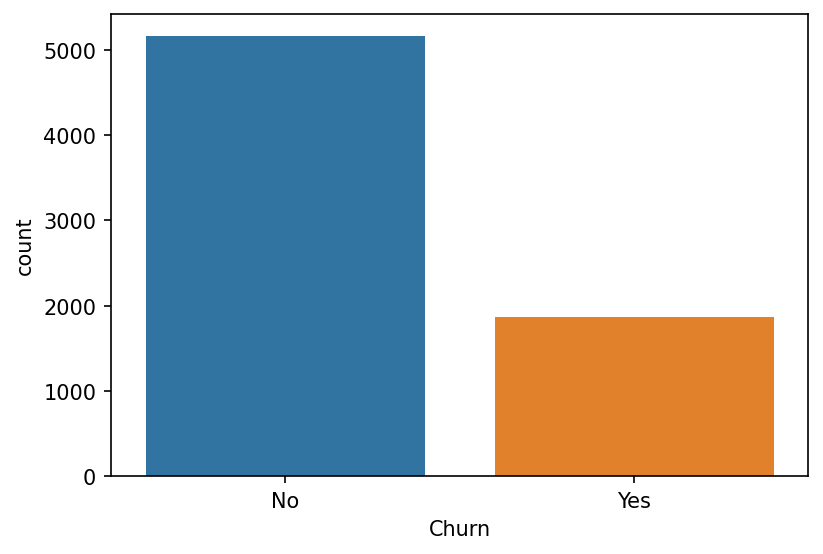

In [188]:
plt.figure (figsize=(6, 4), dpi = 150)
sns.countplot (df, x = 'Churn');

### Распределение колонки 'TotalCharges' по различным значениям 'Churn':

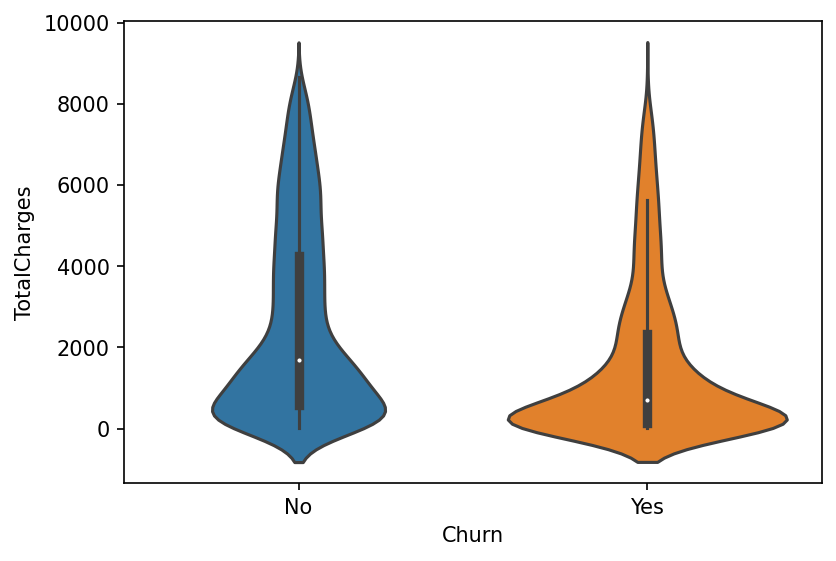

In [187]:
plt.figure (figsize=(6, 4), dpi = 150)
sns.violinplot(data =df, x = 'Churn', y = 'TotalCharges');

### Распределение колонки 'TotalCharges' для различных типов контрактов:

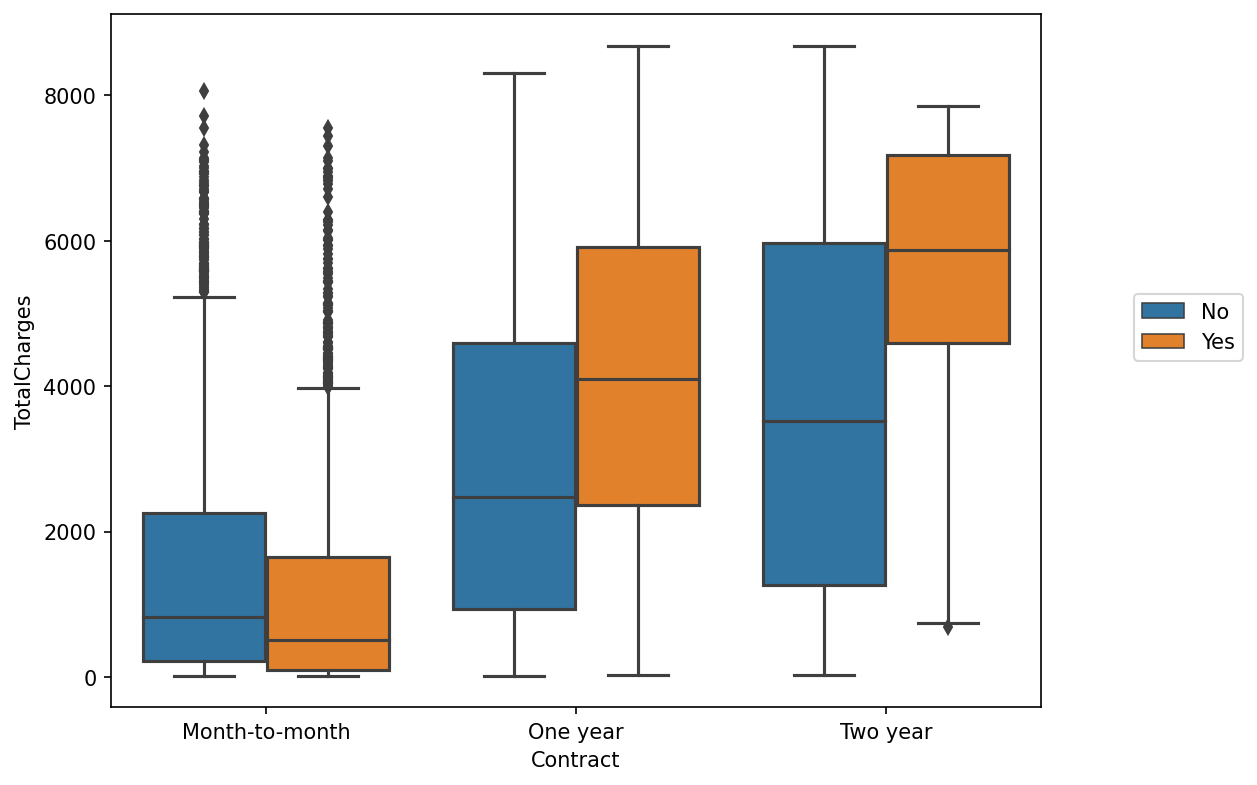

In [5]:
plt.figure (figsize=(8, 6), dpi = 150)
sns.boxplot(data = df, y = 'TotalCharges', x = 'Contract', hue = 'Churn')
plt.legend(loc= (1.1,0.5));

**Заметим тенденцию, что люди, которые больше платят (по колонке 'TotalCharges'), больше уходят в отток.**

### Построим график кореляции признаков с целевой переменной:

In [6]:
corr_df = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 
     'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']]).corr()

In [7]:
corr_yes_churn = corr_df['Churn_Yes'].sort_values().iloc[1:-1]

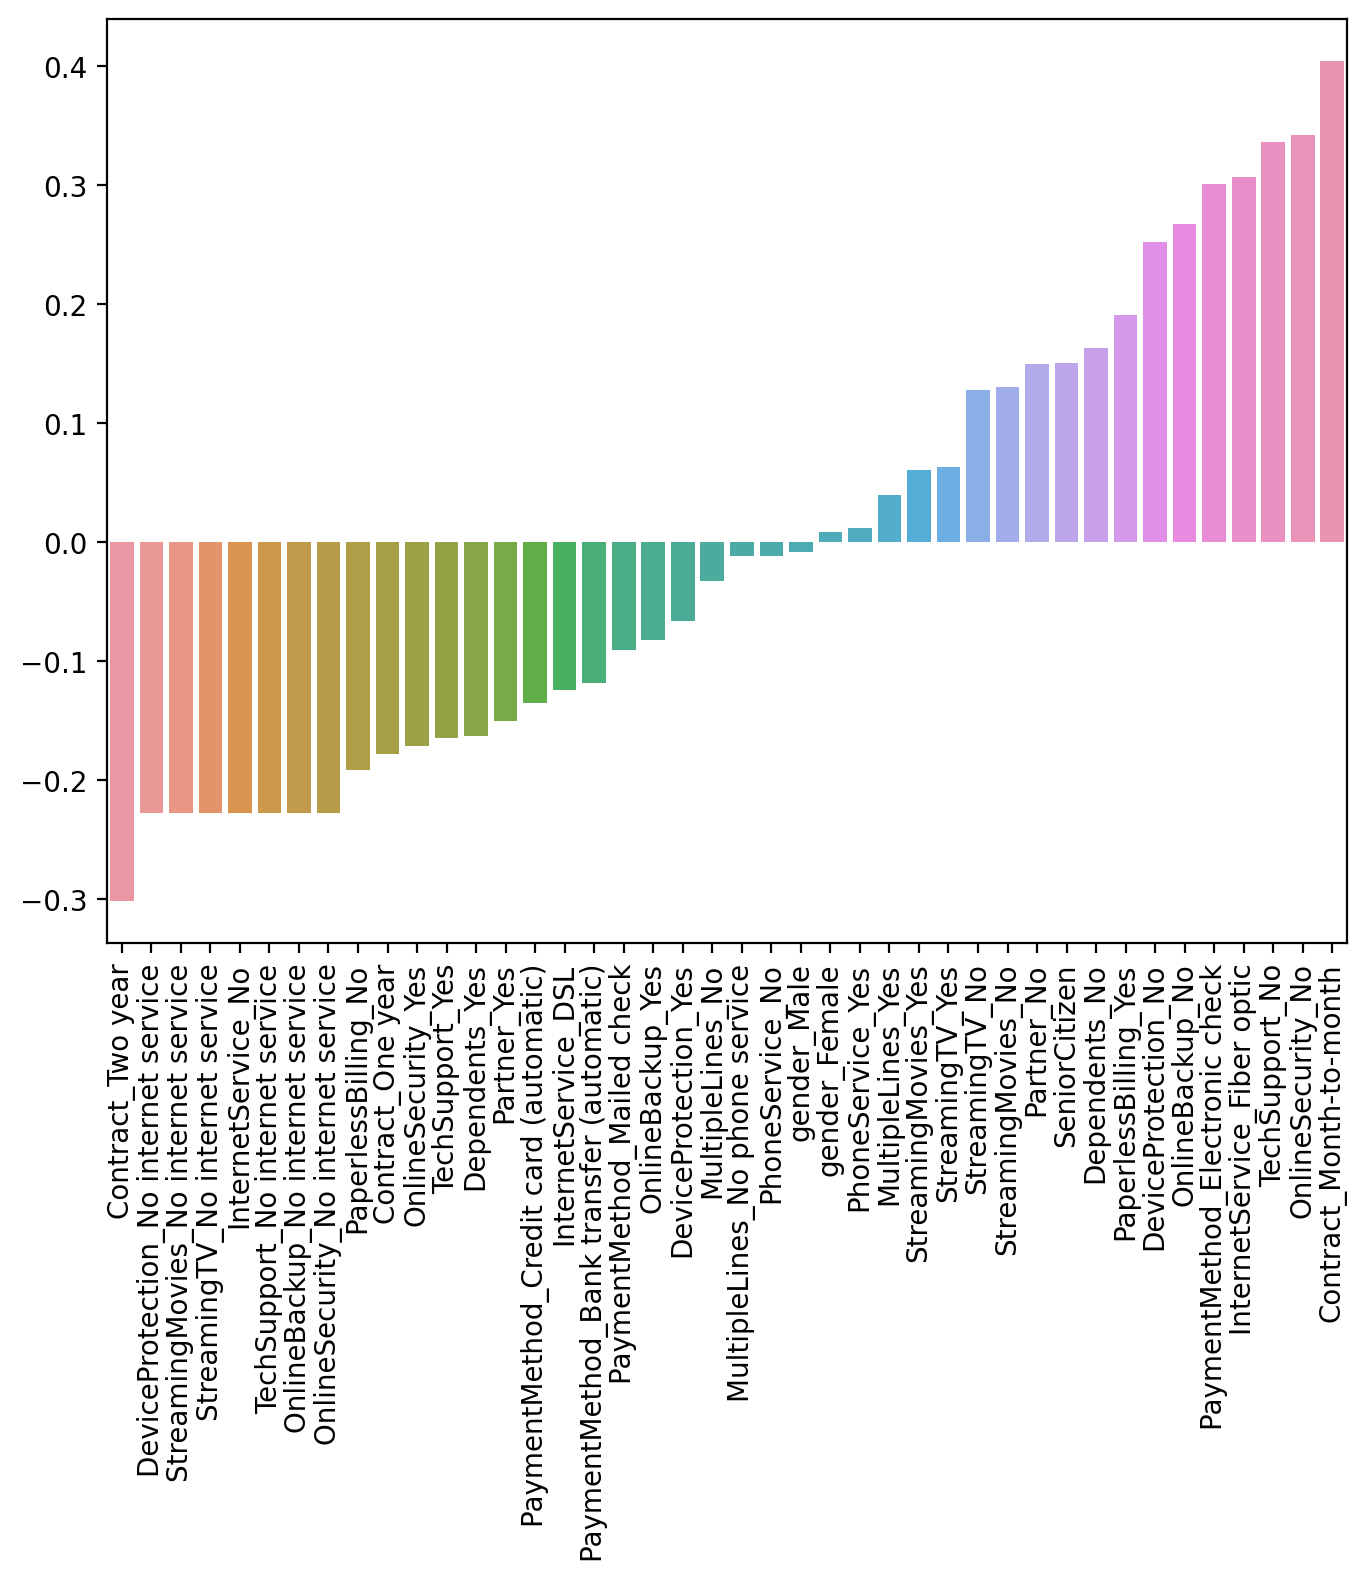

In [196]:
plt.figure(figsize=(8,6), dpi = 200)
sns.barplot(x=corr_yes_churn.index, y = corr_yes_churn.values)
plt.xticks(rotation=90);

-----
## 2) Анализ данных, когортный анализ

Суть когортного анализа — объединение клиентов (пользователей, посетителей) в группы по одинаковым характеристикам или атрибутам и отслеживание их поведения во времени.


Доступно три типа контракта:

In [8]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

### Гистограмма распределения колонки 'tenure' - срок владения договора компании:

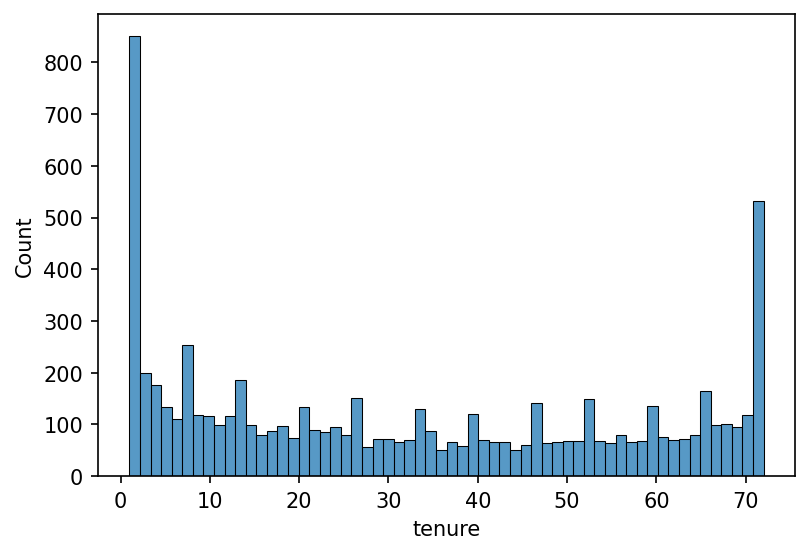

In [197]:
plt.figure (figsize=(6, 4), dpi = 150)
sns.histplot (data=df, x = 'tenure', bins = 60);

### Уходящие/не уходящие в отток в зависимости от вида контракта:

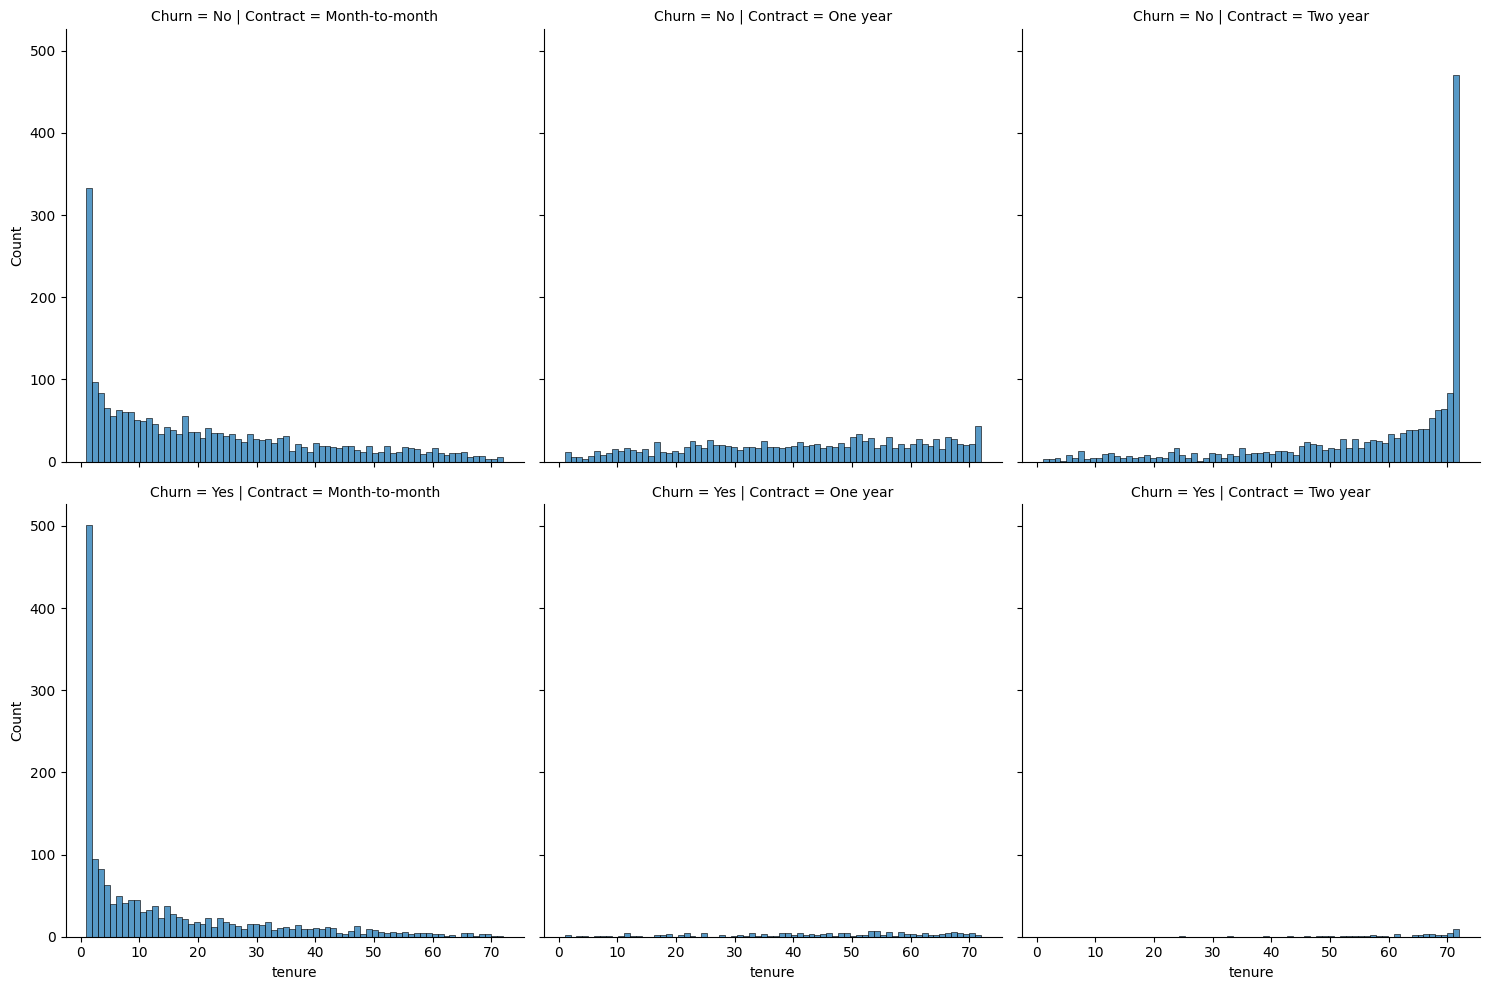

In [199]:
sns.displot (data = df, x = 'tenure', bins = 70, col = 'Contract', row = 'Churn');

* Можем наблюдать зависимость, когда абоненты с контрактами на год и два меньше всего уходят в отток.
* Следовательно, большие усилия можем направить на клиентов с контрактами на месяц - причем самый большой пик оттока, когда клиенты берут договор на месяц или два.

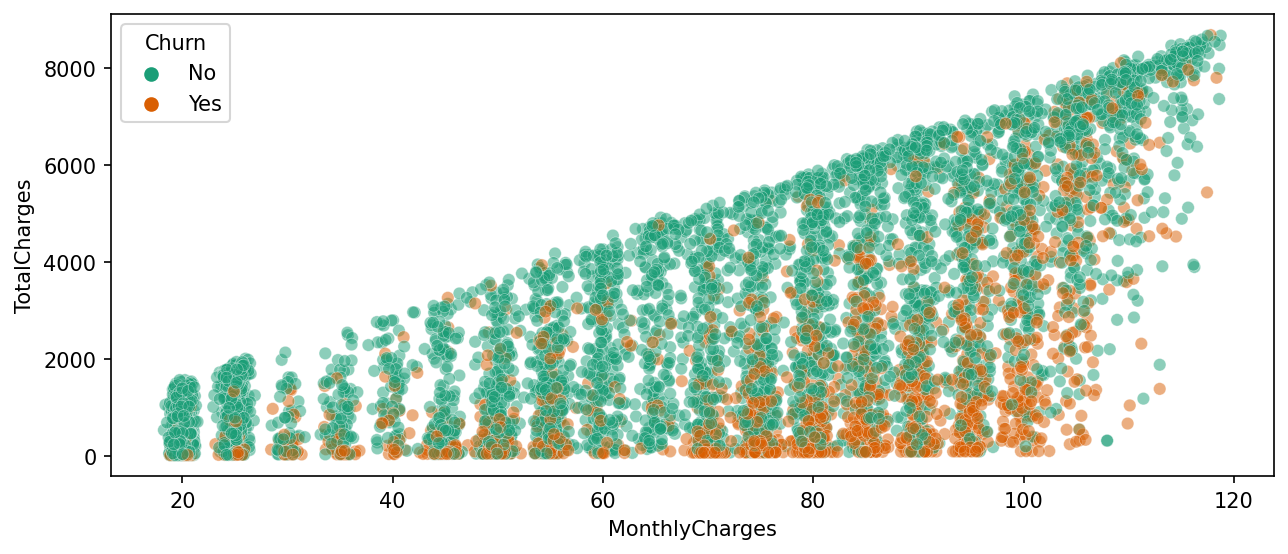

In [9]:
plt.figure (figsize = (10,4), dpi = 150) 
sns.scatterplot(data=df, x = 'MonthlyCharges', y = 'TotalCharges', hue = 'Churn', alpha = 0.5, linewidth = 0.3, palette='Dark2');

**Можем заметить здесь следующее: в отток уходят чаще те, у кого больше ежемесячные расходы.**

### Создание когорт и их анализ

Для начала разделим различные значения колонки 'tenure' (срок владения договора абонентом) в отдельные когорты - 1 месяц, 2 месяца, ... 

Затем посмотрим какой процент людей в когорте ушли в поток. 

In [10]:
xx = df.groupby(['Churn', 'tenure']).count().transpose()
yes_churn = xx['Yes']
no_churn = xx['No']

In [11]:
churn_rate = 100 * yes_churn / (yes_churn + no_churn) 

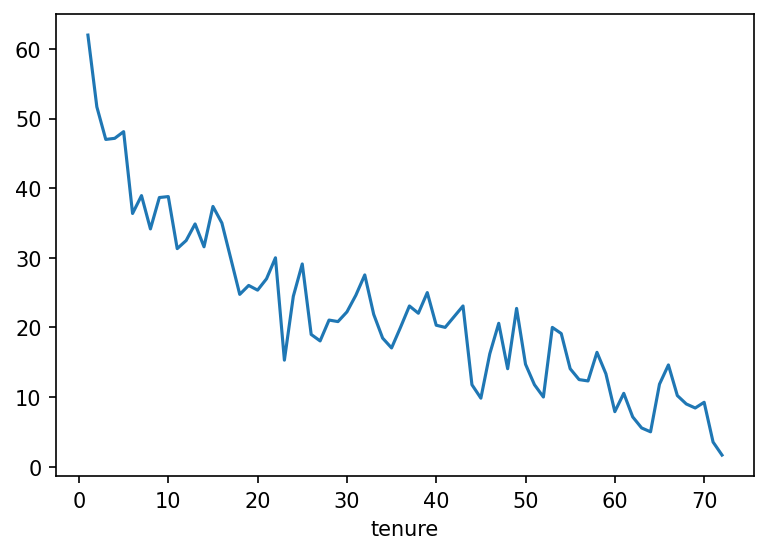

In [12]:
# можем выбрать люую колонку - значения в остальных дублируются, т. к. это количество строк
plt.figure (figsize = (6,4), dpi = 150)
churn_rate.transpose()['customerID'].plot(); 

### Распределим в более крупные когорты

Для этого поделим данные на 4 категории:
   * 0-12 месяцев
   * 12-24 месяца
   * 24-48 месяцев
   * свыше 48 месяцев

In [13]:
def cohort (tenure):
    if tenure < 13:
        return '0-12 месяцев'
    elif tenure < 25:
        return '12-24 месяца'
    elif tenure < 49:
        return '24-48 месяцев'
    else:
        return 'свыше 48 месяцев'

In [14]:
df['Tenure Cohort'] = df['tenure'].apply(cohort)

In [15]:
df[['tenure', 'Tenure Cohort']]

,tenure,Tenure Cohort
0,1,0-12 месяцев
1,34,24-48 месяцев
2,2,0-12 месяцев
3,45,24-48 месяцев
4,2,0-12 месяцев
...,...,...
7027,24,12-24 месяца
7028,72,свыше 48 месяцев
7029,11,0-12 месяцев
7030,4,0-12 месяцев


### График расходов (Charges) по когортам:

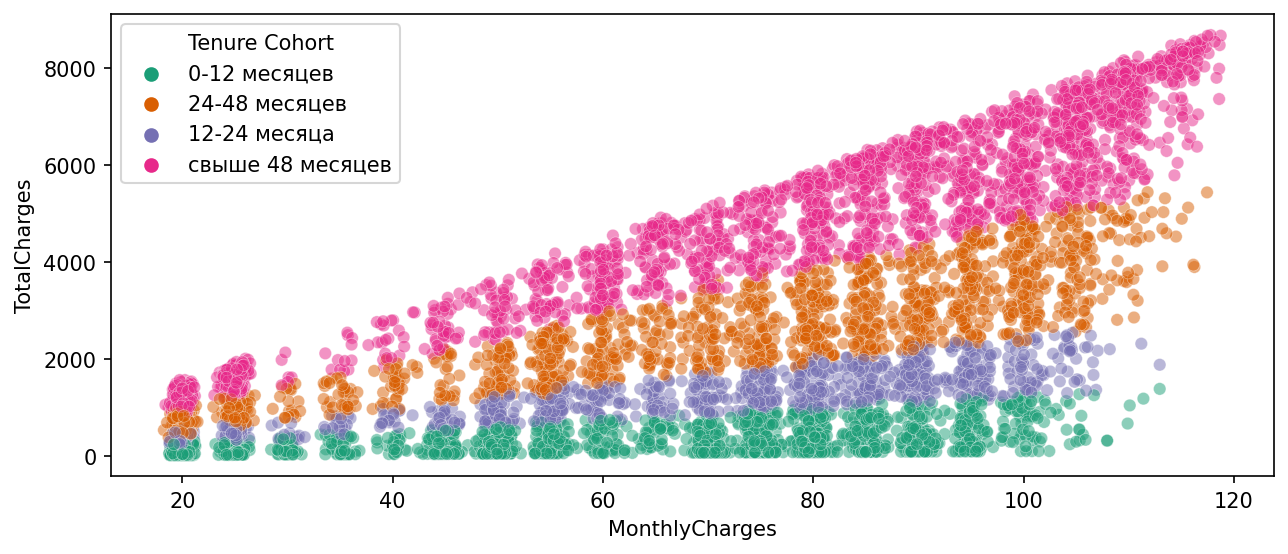

In [16]:
plt.figure (figsize = (10, 4), dpi = 150)
sns.scatterplot (data = df, y = 'TotalCharges', x = 'MonthlyCharges', hue = 'Tenure Cohort', palette = 'Dark2', alpha = 0.5, linewidth = 0.3); 

### График оттока клиентов по отдельным когортам:

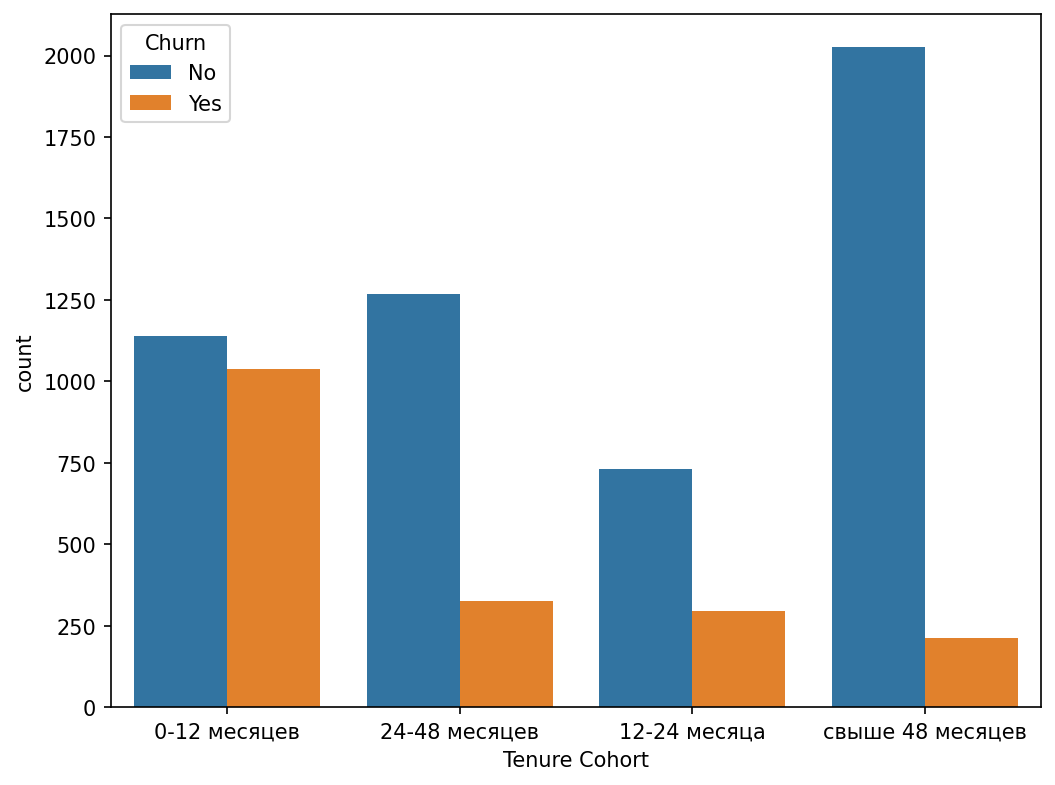

In [17]:
plt.figure (figsize = (8, 6), dpi = 150)
sns.countplot(data = df, x = 'Tenure Cohort', hue = 'Churn');

* Клиенты с длительностью обслуживания контракта более 48 месяцев менее склонны уходить в отток. 
* Если человек пользуется контрактом от 0 до 12 месяцев, вероятность уйти в отток заментно выше.

-----

## 3) Модель

Разбиение на обучающую и тестовую выборки, обозначение целевой переменной.

In [18]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure Cohort
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 месяцев
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,24-48 месяцев
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 месяцев


In [19]:
X = df.drop(['customerID', 'Churn'], axis = 1)
y = df['Churn']

In [20]:
X = pd.get_dummies(X, drop_first = True)

In [21]:
import sklearn
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.1)

### Дерево решений

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
dt_c = DecisionTreeClassifier(max_depth=6)

In [25]:
dt_c.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6)

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [27]:
preds = dt_c.predict (X_test)

In [28]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.87      0.89      0.88       557
         Yes       0.55      0.49      0.52       147

    accuracy                           0.81       704
   macro avg       0.71      0.69      0.70       704
weighted avg       0.80      0.81      0.81       704



Можем наблюдать не очень хорошую статистику предсказания для класса 'No Churn' - это может быть связано с инзначальной не сбалансированностью в данных.

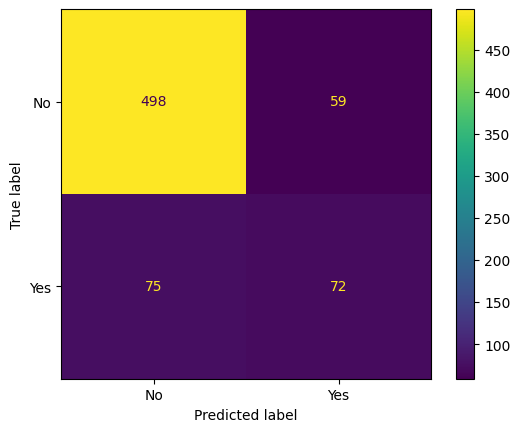

In [29]:
ConfusionMatrixDisplay.from_estimator(dt_c, X_test, y_test);

Нам нужно минимизировать конкретно число тех, кто был ошибочно определен в класс "Не уйдет в отток", но отток случился (75 объектов, метрика 'Recall')

В таком случае мы упустим тех, кто уходит в отток, и потеряем прибыль.

Также модель неправильно предсказала 59 объектов, дав предсказание, что клиент уйдет в отток, но такого не произошло.

**Посмотрим, какие признаки использовались в дереве решений.**

In [30]:
importance_features = pd.DataFrame (data = dt_c.feature_importances_, index = X.columns, columns=['Важность']) 

In [31]:
importance_features = importance_features.sort_values('Важность')
importance_features = importance_features[importance_features['Важность'] > 0]

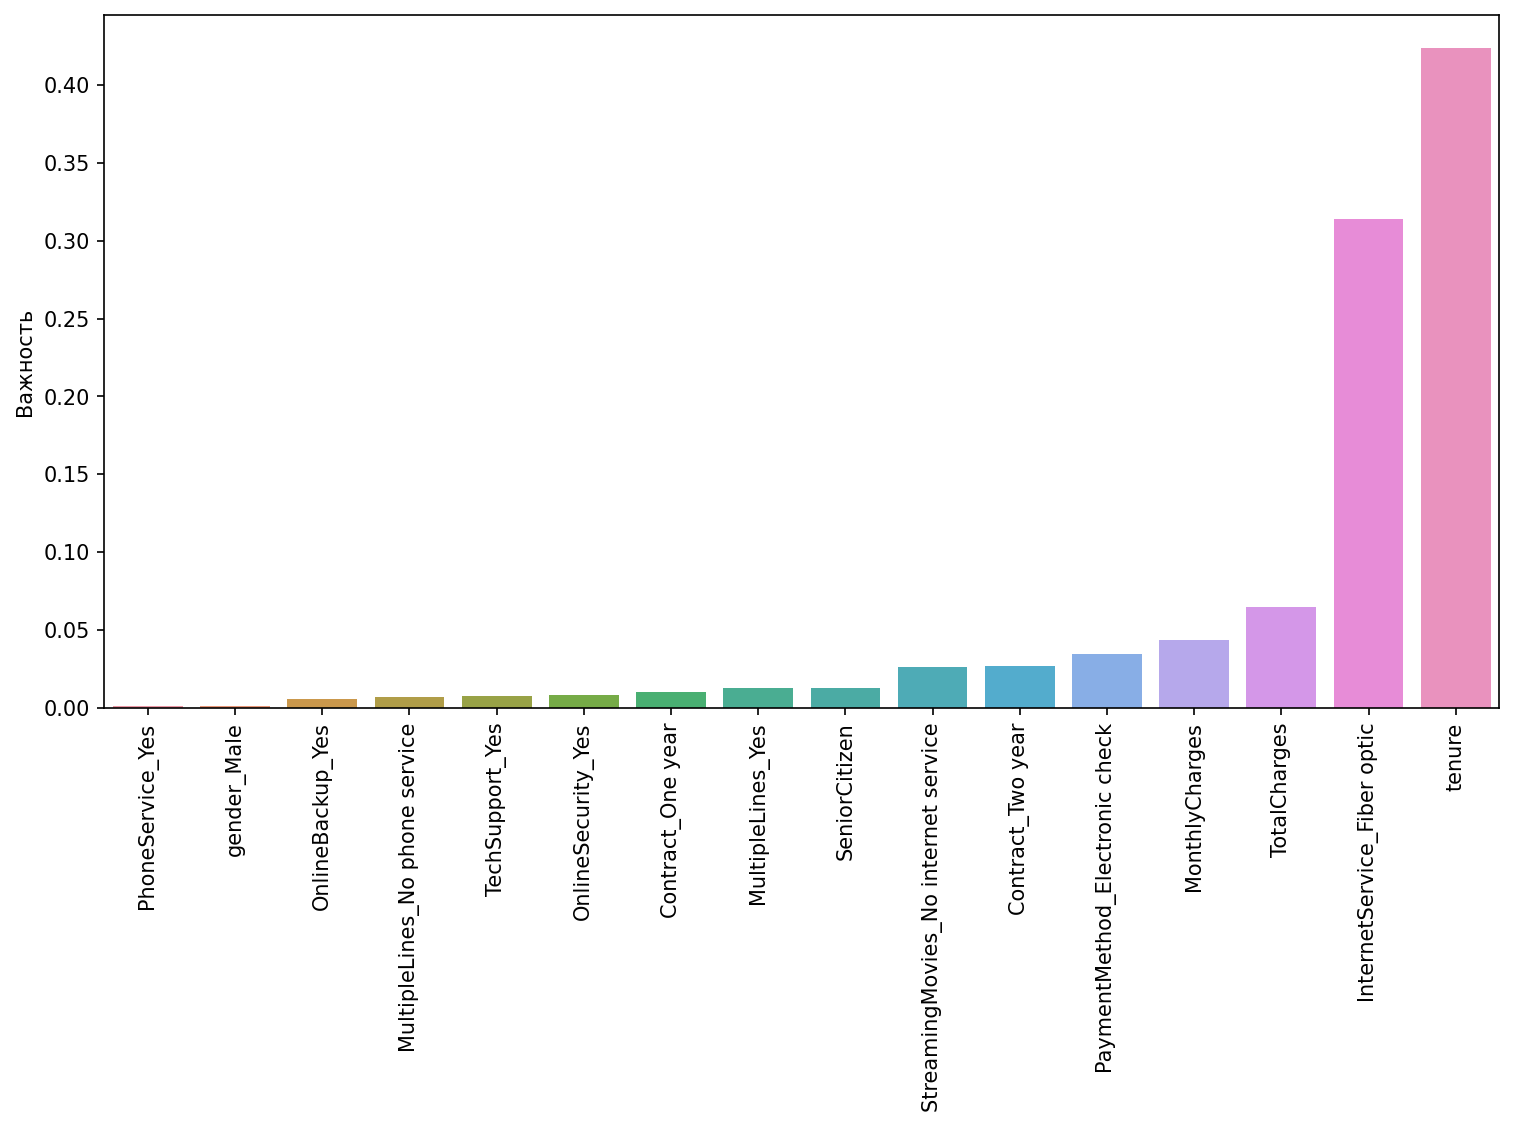

In [32]:
plt.figure (figsize = (12,6), dpi = 150)
sns.barplot(data = importance_features, x = importance_features.index, y = 'Важность')
plt.xticks(rotation = 90);

**Люди, которым важен интернет по оптоволокну, чаще уходят в отток (InternetService_Fiber optic).**

### Случайный лес

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rf_c = RandomForestClassifier(max_depth = 6)

In [35]:
rf_c.fit(X_train, y_train)

RandomForestClassifier(max_depth=6)

In [36]:
preds = rf_c.predict (X_test)

In [37]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          No       0.86      0.92      0.89       557
         Yes       0.61      0.45      0.52       147

    accuracy                           0.82       704
   macro avg       0.73      0.69      0.70       704
weighted avg       0.81      0.82      0.81       704



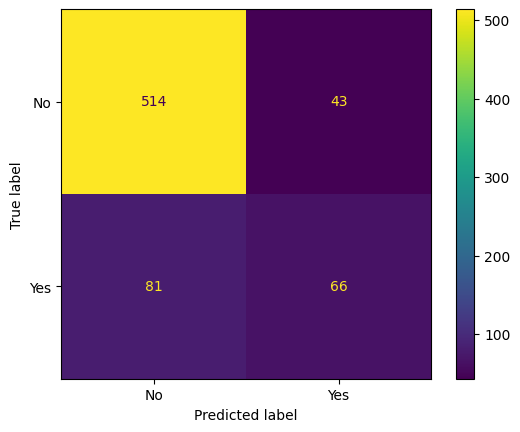

In [38]:
ConfusionMatrixDisplay.from_estimator(rf_c, X_test, y_test);

**Модель работает хуже - 84 объектов, ошибочно определенных в класс "Не уйдет в отток", но отток случился.**

### Бустинг

In [39]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [40]:
Ada_b = AdaBoostClassifier()
Gr_b = GradientBoostingClassifier()

In [41]:
Ada_b.fit(X_train, y_train)

AdaBoostClassifier()

In [42]:
Gr_b.fit(X_train, y_train)

GradientBoostingClassifier()

In [43]:
Ada_preds = Ada_b.predict(X_test)
Gr_preds = Gr_b.predict(X_test)

In [44]:
print(classification_report(y_test,Ada_preds))

              precision    recall  f1-score   support

          No       0.88      0.90      0.89       557
         Yes       0.60      0.54      0.57       147

    accuracy                           0.83       704
   macro avg       0.74      0.72      0.73       704
weighted avg       0.82      0.83      0.83       704



In [45]:
print(classification_report(y_test,Gr_preds))

              precision    recall  f1-score   support

          No       0.87      0.90      0.89       557
         Yes       0.57      0.50      0.53       147

    accuracy                           0.82       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.81      0.82      0.81       704



**Результаты градиентного бустинга**

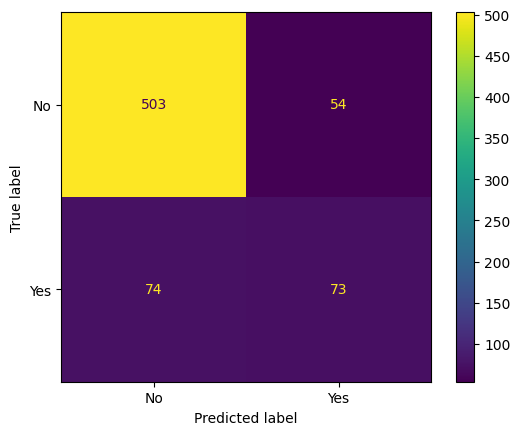

In [46]:
ConfusionMatrixDisplay.from_estimator(Gr_b, X_test, y_test);

**Результаты адаптивного бустинга**

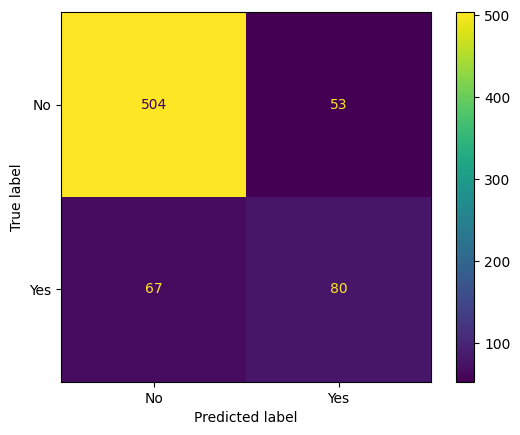

In [47]:
ConfusionMatrixDisplay.from_estimator(Ada_b, X_test, y_test);

* Лучше всего отработала модель адаптивного бустинга. 
* Она имеет меньше всего объектов, ошибочно определенных в класс "Не уйдет в отток", но при этом отток случился.

### Сделаем поиск по сетке

In [48]:
from sklearn.model_selection import GridSearchCV 

In [49]:
param_grid = {'n_estimators' : [25, 50, 100, 150]}

In [50]:
grid_model = GridSearchCV(estimator = Ada_b,
                          param_grid=param_grid,
                          cv=5,
                          verbose=1

)

In [51]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [25, 50, 100, 150]}, verbose=1)

**Лучшая комбинация параметров для модели**

In [52]:
grid_model.best_params_

{'n_estimators': 25}

In [53]:
preds = grid_model.predict(X_test)

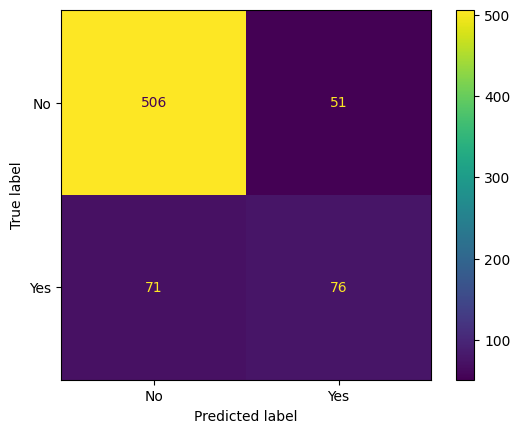

In [54]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test);